<a href="https://colab.research.google.com/github/NahianAlindo/gait_recognition/blob/main/MLSTM%20FCN-SE_Standard_Block_Gait_Recognition_1_4__OU_ISIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive & GPU Status

In [ ]:
! nvidia-smi

Thu Nov 25 09:51:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install keras_tuner

     |████████████████████████████████| 98 kB 3.5 MB/s 


# Import libraries

In [ ]:
import tensorflow
from tensorflow import keras
import keras_tuner as kt
import os
import numpy as np
# import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Permute, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, concatenate, multiply, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.constraints import max_norm as maxnorm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import tensorflow.keras.metrics as metrics
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Number of classes for dataset 1

In [ ]:
num_classes = 118

# Utility functions for loading datasets, plots and test performance

In [ ]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [ ]:
def plot_performance(X_train, train_label):
    history = model.fit(X_train, train_label, validation_split = 0.1, epochs=100, shuffle=True, batch_size=512, callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=50))#, callbacks=[es_callback])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
def get_test_performance(model, X_test, test_label):
    score=model.evaluate(X_test,test_label,verbose=1)
    print(f'Test loss:{score[0]}')
    print(f'Test accuracy:{score[1]}')
    print(f'Test Recall: {score[3]}')
    print(f'Test AUC: {score[2]}')

# Squeeze Excite Block

In [ ]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    # channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # if K.image_data_format() == 'channels_first':
    #     se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

# Dataset 1

In [ ]:
i=0

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
batch_size = 32

# optimization with keras tuner

### Model with Post-SE (Standard)

In [ ]:
def post_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Choice('lstm_1', values = [8,16,32,64,128,256,512]))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Choice('conv_1_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_1_filter_stride', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_2_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_2_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_3_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_3_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    # batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer='adam', \
                  loss='categorical_crossentropy',metrics=['accuracy','AUC'])
    # model.summary()

    return model

In [ ]:
i+=1
tuner = kt.tuners.BayesianOptimization(post_se,
    objective='val_accuracy',
    max_trials=100,
    seed=42,
    project_name=f'Model{i}')
# Will stop training if the "val_loss" hasn't improved in 3 epochs.
tuner.search(X_train, train_label, epochs=200, callbacks=[EarlyStopping('val_loss', patience=30),ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)],validation_split=0.1, shuffle=True)

Trial 6 Complete [01h 28m 05s]
val_accuracy: 0.9972817897796631

Best val_accuracy So Far: 0.9972817897796631
Total elapsed time: 05h 26m 33s

Search: Running Trial #7

Hyperparameter    |Value             |Best Value So Far 
lstm_1            |8                 |8                 
Dropout           |0.7               |0.7               
conv_1_filter     |32                |32                
conv_1_filter_s...|3                 |9                 
conv_2_filter     |512               |512               
conv_2_filter_s...|3                 |9                 
conv_3_filter     |512               |512               
conv_3_filter_s...|9                 |9                 

Epoch 1/200
932/932 [==============================] - 63s 61ms/step - loss: 0.7186 - accuracy: 0.8469 - auc: 0.9910 - val_loss: 0.2477 - val_accuracy: 0.9272 - val_auc: 0.9981 - lr: 0.0010
Epoch 2/200
932/932 [==============================] - 54s 58ms/step - loss: 0.1405 - accuracy: 0.9659 - auc: 0.9988 - val_loss

In [ ]:
tuner.results_summary(max_trials=100)

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

In [ ]:
model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

In [ ]:
tensorflow.keras.utils.plot_model(
    model, to_file='MLSTM_FCN_tuned.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [ ]:
get_test_performance(model, X_test, test_label):

#### post-SE Tuning

In [ ]:
class MyTuner(kt.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    hp = trial.hyperparameters
    model = self.hypermodel.build(hp)
    batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    # kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

tuner = kt.tuners.RandomSearch(post_se,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    project_name='Model6')
# Will stop training if the "val_loss" hasn't improved in 3 epochs.
tuner.search(X_train, train_label, epochs=200, validation_split=0.2, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

### Model with Pre-SE

In [ ]:
def pre_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Choice('lstm_1', values = [8,16,32,64,128,256,512,1024,2048,4096]))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_1_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_1_filter_stride', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_2_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_2_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv1D(hp.Choice('conv_3_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_3_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    # batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

#### Pre-SE Tuning

In [ ]:
i = 1

In [ ]:
# class MyTuner(kt.tuners.RandomSearch):
#   def run_trial(self, trial, *args, **kwargs):
#     # You can add additional HyperParameters for preprocessing and custom training loops
#     # via overriding `run_trial`
#     hp = trial.hyperparameters
#     model = self.hypermodel.build(hp)
#     batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
#     # kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
#     super(MyTuner, self).run_trial(trial, *args, **kwargs)


i += 1
tuner = kt.tuners.RandomSearch(pre_se,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    project_name=f'Model{i}')
# Will stop training if the "val_loss" hasn't improved in 3 epochs.
tuner.search(X_train, train_label, epochs=200, validation_split=0.2, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
lstm_1            |1632              |?                 
Dropout           |0.1               |?                 
conv_1_filter     |2048              |?                 
conv_1_filter_s...|7                 |?                 
conv_2_filter     |64                |?                 
conv_2_filter_s...|7                 |?                 
conv_3_filter     |1024              |?                 
conv_3_filter_s...|3                 |?                 
learning_rate     |0.0001            |?                 

Epoch 1/200
828/828 [==============================] - 114s 94ms/step - loss: 0.9025 - accuracy: 0.7990 - val_loss: 0.3156 - val_accuracy: 0.9225
Epoch 2/200
828/828 [==============================] - 75s 91ms/step - loss: 0.2164 - accuracy: 0.9474 - val_loss: 0.2160 - val_accuracy: 0.9447
Epoch 3/200
828/828 [==============================] - 75s 91ms/step - loss: 0.1145 - accuracy: 0.9726 - val_lo

### Model with Identity SE

In [ ]:
def identity_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Choice('lstm_1', values = [8,16,32,64,128,256,512,1024,2048,4096]))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Choice('conv_1_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_1_filter_stride', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_2_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_2_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_3_filter', values = [32,64,128,256,512,1024,2048,4096]), hp.Choice(name='conv_3_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

### Identity SE Tuning

In [ ]:
class MyTuner(kt.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    hp = trial.hyperparameters
    model = self.hypermodel.build(hp)
    batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    # kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

tuner = kt.tuners.RandomSearch(identity_se,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    project_name='Model6')
# Will stop training if the "val_loss" hasn't improved in 3 epochs.
tuner.search(X_train, train_label, epochs=200, validation_split=0.2, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

In [ ]:
print(dir(kt.tuners))

['BayesianOptimization', 'Hyperband', 'RandomSearch', 'Sklearn', 'SklearnTuner', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'bayesian', 'hyperband', 'randomsearch', 'sklearn_tuner']


In [ ]:
layers = ['lstm_1', 'Dropout', 'conv_1_filter', 'conv_1_filter_stride', 'conv_2_filter', 'conv_2_filter_stride', 'conv_3_filter', 'conv_3_filter_stride', 'learning_rate']
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print('Optimal Hyperparameters:')
for i in layers:
    print(f"{i}: {best_hyperparameters.get(i)}")

Optimal Hyperparameters:
lstm_1: 128
Dropout: 0.6
conv_1_filter: 512
conv_1_filter_stride: 8
conv_2_filter: 128
conv_2_filter_stride: 8
conv_3_filter: 2048
conv_3_filter_stride: 7
learning_rate: 0.01


In [ ]:
model = tensorflow.keras.models.load_model('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_tuned.h5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 128)     6272        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128)    512         ['conv1d[0][0]']                 
 alization)                                                                                   

# The best models start from here using POST-SE

In [ ]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

# New and Improved

In [ ]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=8)(x)
    x = Dropout(0.7)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(32, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

In [ ]:
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 32)      1760        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 32)     128         ['conv1d[0][0]']                 
 alization)                                                                                   

# Dataset 1

In [ ]:
model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

Epoch 1/200
932/932 [==============================] - 72s 61ms/step - loss: 0.6630 - accuracy: 0.8548 - auc: 0.9920 - recall: 0.7575 - val_loss: 0.1598 - val_accuracy: 0.9641 - val_auc: 0.9979 - val_recall: 0.9511
Epoch 2/200
932/932 [==============================] - 54s 58ms/step - loss: 0.1257 - accuracy: 0.9689 - auc: 0.9990 - recall: 0.9571 - val_loss: 0.1291 - val_accuracy: 0.9656 - val_auc: 0.9986 - val_recall: 0.9574
Epoch 3/200
932/932 [==============================] - 54s 58ms/step - loss: 0.0850 - accuracy: 0.9776 - auc: 0.9994 - recall: 0.9706 - val_loss: 0.0689 - val_accuracy: 0.9831 - val_auc: 0.9991 - val_recall: 0.9764
Epoch 4/200
932/932 [==============================] - 54s 58ms/step - loss: 0.0635 - accuracy: 0.9833 - auc: 0.9995 - recall: 0.9775 - val_loss: 0.0727 - val_accuracy: 0.9807 - val_auc: 0.9994 - val_recall: 0.9731
Epoch 5/200
932/932 [==============================] - 54s 58ms/step - loss: 0.0535 - accuracy: 0.9849 - auc: 0.9997 - recall: 0.9804 - val_

In [ ]:
score=model.evaluate(X_test,test_label,verbose=1)
print(f'Test loss:{score[0]}')
print(f'Test accuracy:{score[1]}')
print(f'Test Recall: {score[3]}')
print(f'Test AUC: {score[2]}')

117/117 [==============================] - 3s 23ms/step - loss: 0.5011 - accuracy: 0.9481 - auc: 0.9819 - recall: 0.9468
Test loss:0.5011071562767029
Test accuracy:0.948128342628479
Test Recall: 0.9467914700508118
Test AUC: 0.9818675518035889


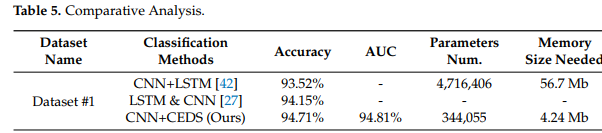

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
batch_size = 32

# Dataset 2

In [ ]:
num_classes=20
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
score=model.evaluate(X_test,test_label,verbose=1)
print(f'Test loss:{score[0]}')
print(f'Test accuracy:{score[1]}')
print(f'Test Recall: {score[3]}')
print(f'Test AUC: {score[2]}')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 32)      1760        ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 32)     128         ['conv1d_3[0][0]']               
 rmalization)                                                                               

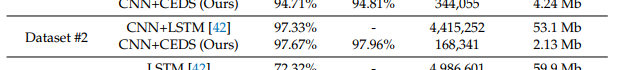

In [ ]:
model.save('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_dataset2_97_43_AUC_98_89.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Dataset OU-ISIR

In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 32)      1760        ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 32)     128         ['conv1d_6[0][0]']               
 rmalization)                                          

In [ ]:
model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
score=model.evaluate(X_test,test_label,verbose=1)
print(f'Test loss:{score[0]}')
print(f'Test accuracy:{score[1]}')
print(f'Test Recall: {score[3]}')
print(f'Test AUC: {score[2]}')

Epoch 1/200
372/372 [==============================] - 32s 66ms/step - loss: 5.1564 - accuracy: 0.1093 - auc: 0.7420 - recall: 0.0043 - val_loss: 4.1328 - val_accuracy: 0.1392 - val_auc: 0.8674 - val_recall: 0.0076
Epoch 2/200
372/372 [==============================] - 22s 60ms/step - loss: 2.0968 - accuracy: 0.5465 - auc: 0.9846 - recall: 0.1806 - val_loss: 1.9100 - val_accuracy: 0.5091 - val_auc: 0.9739 - val_recall: 0.2965
Epoch 3/200
372/372 [==============================] - 22s 60ms/step - loss: 0.8089 - accuracy: 0.8346 - auc: 0.9978 - recall: 0.6263 - val_loss: 0.9807 - val_accuracy: 0.7436 - val_auc: 0.9922 - val_recall: 0.5923
Epoch 4/200
372/372 [==============================] - 22s 60ms/step - loss: 0.3882 - accuracy: 0.9251 - auc: 0.9994 - recall: 0.8376 - val_loss: 0.4438 - val_accuracy: 0.9017 - val_auc: 0.9969 - val_recall: 0.8230
Epoch 5/200
372/372 [==============================] - 22s 60ms/step - loss: 0.2150 - accuracy: 0.9606 - auc: 0.9998 - recall: 0.9192 - val_

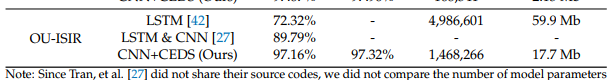

<!-- MLSTM-FCN on OU-ISIR

Test loss:0.15832865238189697


Test accuracy:0.9687721729278564


<!-- Test Recall: 0.9652235507965088 -->


Test AUC: 0.9950261116027832 -->

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 24ms/step - loss: 0.2084 - accuracy: 0.9489 - auc: 0.9950 - recall: 0.9446
Test loss:0.20843596756458282
Test accuracy:0.9488999247550964
Test Recall: 0.9446415901184082
Test AUC: 0.9950188398361206


# Dataset 3

In [ ]:
num_classes = 118
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/test/y_test.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(26283, 6, 128, 1) (2991, 6, 128, 1)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 128, 6)       0           ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 128, 32)      1760        ['permute_3[0][0]']              
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 32)     128         ['conv1d_9[0][0]']               
 rmalization)                                          

In [ ]:
model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
get_test_performance(model, X_test, test_label)

Epoch 1/200
740/740 [==============================] - 53s 61ms/step - loss: 0.7460 - accuracy: 0.8329 - auc: 0.9905 - recall: 0.7256 - val_loss: 0.1744 - val_accuracy: 0.9585 - val_auc: 0.9987 - val_recall: 0.9426
Epoch 2/200
740/740 [==============================] - 43s 58ms/step - loss: 0.1243 - accuracy: 0.9683 - auc: 0.9991 - recall: 0.9572 - val_loss: 0.0896 - val_accuracy: 0.9783 - val_auc: 0.9984 - val_recall: 0.9722
Epoch 3/200
740/740 [==============================] - 43s 58ms/step - loss: 0.0773 - accuracy: 0.9794 - auc: 0.9996 - recall: 0.9724 - val_loss: 0.0789 - val_accuracy: 0.9829 - val_auc: 0.9990 - val_recall: 0.9757
Epoch 4/200
740/740 [==============================] - 44s 59ms/step - loss: 0.0586 - accuracy: 0.9839 - auc: 0.9996 - recall: 0.9792 - val_loss: 0.1286 - val_accuracy: 0.9627 - val_auc: 0.9980 - val_recall: 0.9559
Epoch 5/200
740/740 [==============================] - 44s 60ms/step - loss: 0.0493 - accuracy: 0.9868 - auc: 0.9997 - recall: 0.9823 - val_

# Dataset 4

In [ ]:
num_classes = 20
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/test/y_test.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(35373, 6, 128, 1) (3941, 6, 128, 1)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_4 (Permute)            (None, 128, 6)       0           ['input_5[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 128, 32)      1760        ['permute_4[0][0]']              
                                                                                                  
 batch_normalization_12 (BatchN  (None, 128, 32)     128         ['conv1d_12[0][0]']              
 ormalization)                                         

In [ ]:
model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
get_test_performance(model, X_test, test_label)

Epoch 1/200
995/995 [==============================] - 66s 60ms/step - loss: 0.1673 - accuracy: 0.9588 - auc: 0.9979 - recall: 0.9410 - val_loss: 0.1208 - val_accuracy: 0.9712 - val_auc: 0.9970 - val_recall: 0.9681
Epoch 2/200
995/995 [==============================] - 57s 58ms/step - loss: 0.0400 - accuracy: 0.9895 - auc: 0.9995 - recall: 0.9876 - val_loss: 0.0445 - val_accuracy: 0.9898 - val_auc: 0.9992 - val_recall: 0.9887
Epoch 3/200
995/995 [==============================] - 57s 57ms/step - loss: 0.0234 - accuracy: 0.9934 - auc: 0.9997 - recall: 0.9923 - val_loss: 0.0565 - val_accuracy: 0.9876 - val_auc: 0.9988 - val_recall: 0.9859
Epoch 4/200
995/995 [==============================] - 59s 59ms/step - loss: 0.0235 - accuracy: 0.9932 - auc: 0.9997 - recall: 0.9924 - val_loss: 0.0467 - val_accuracy: 0.9845 - val_auc: 0.9991 - val_recall: 0.9839
Epoch 5/200
995/995 [==============================] - 59s 59ms/step - loss: 0.0156 - accuracy: 0.9955 - auc: 0.9999 - recall: 0.9948 - val_

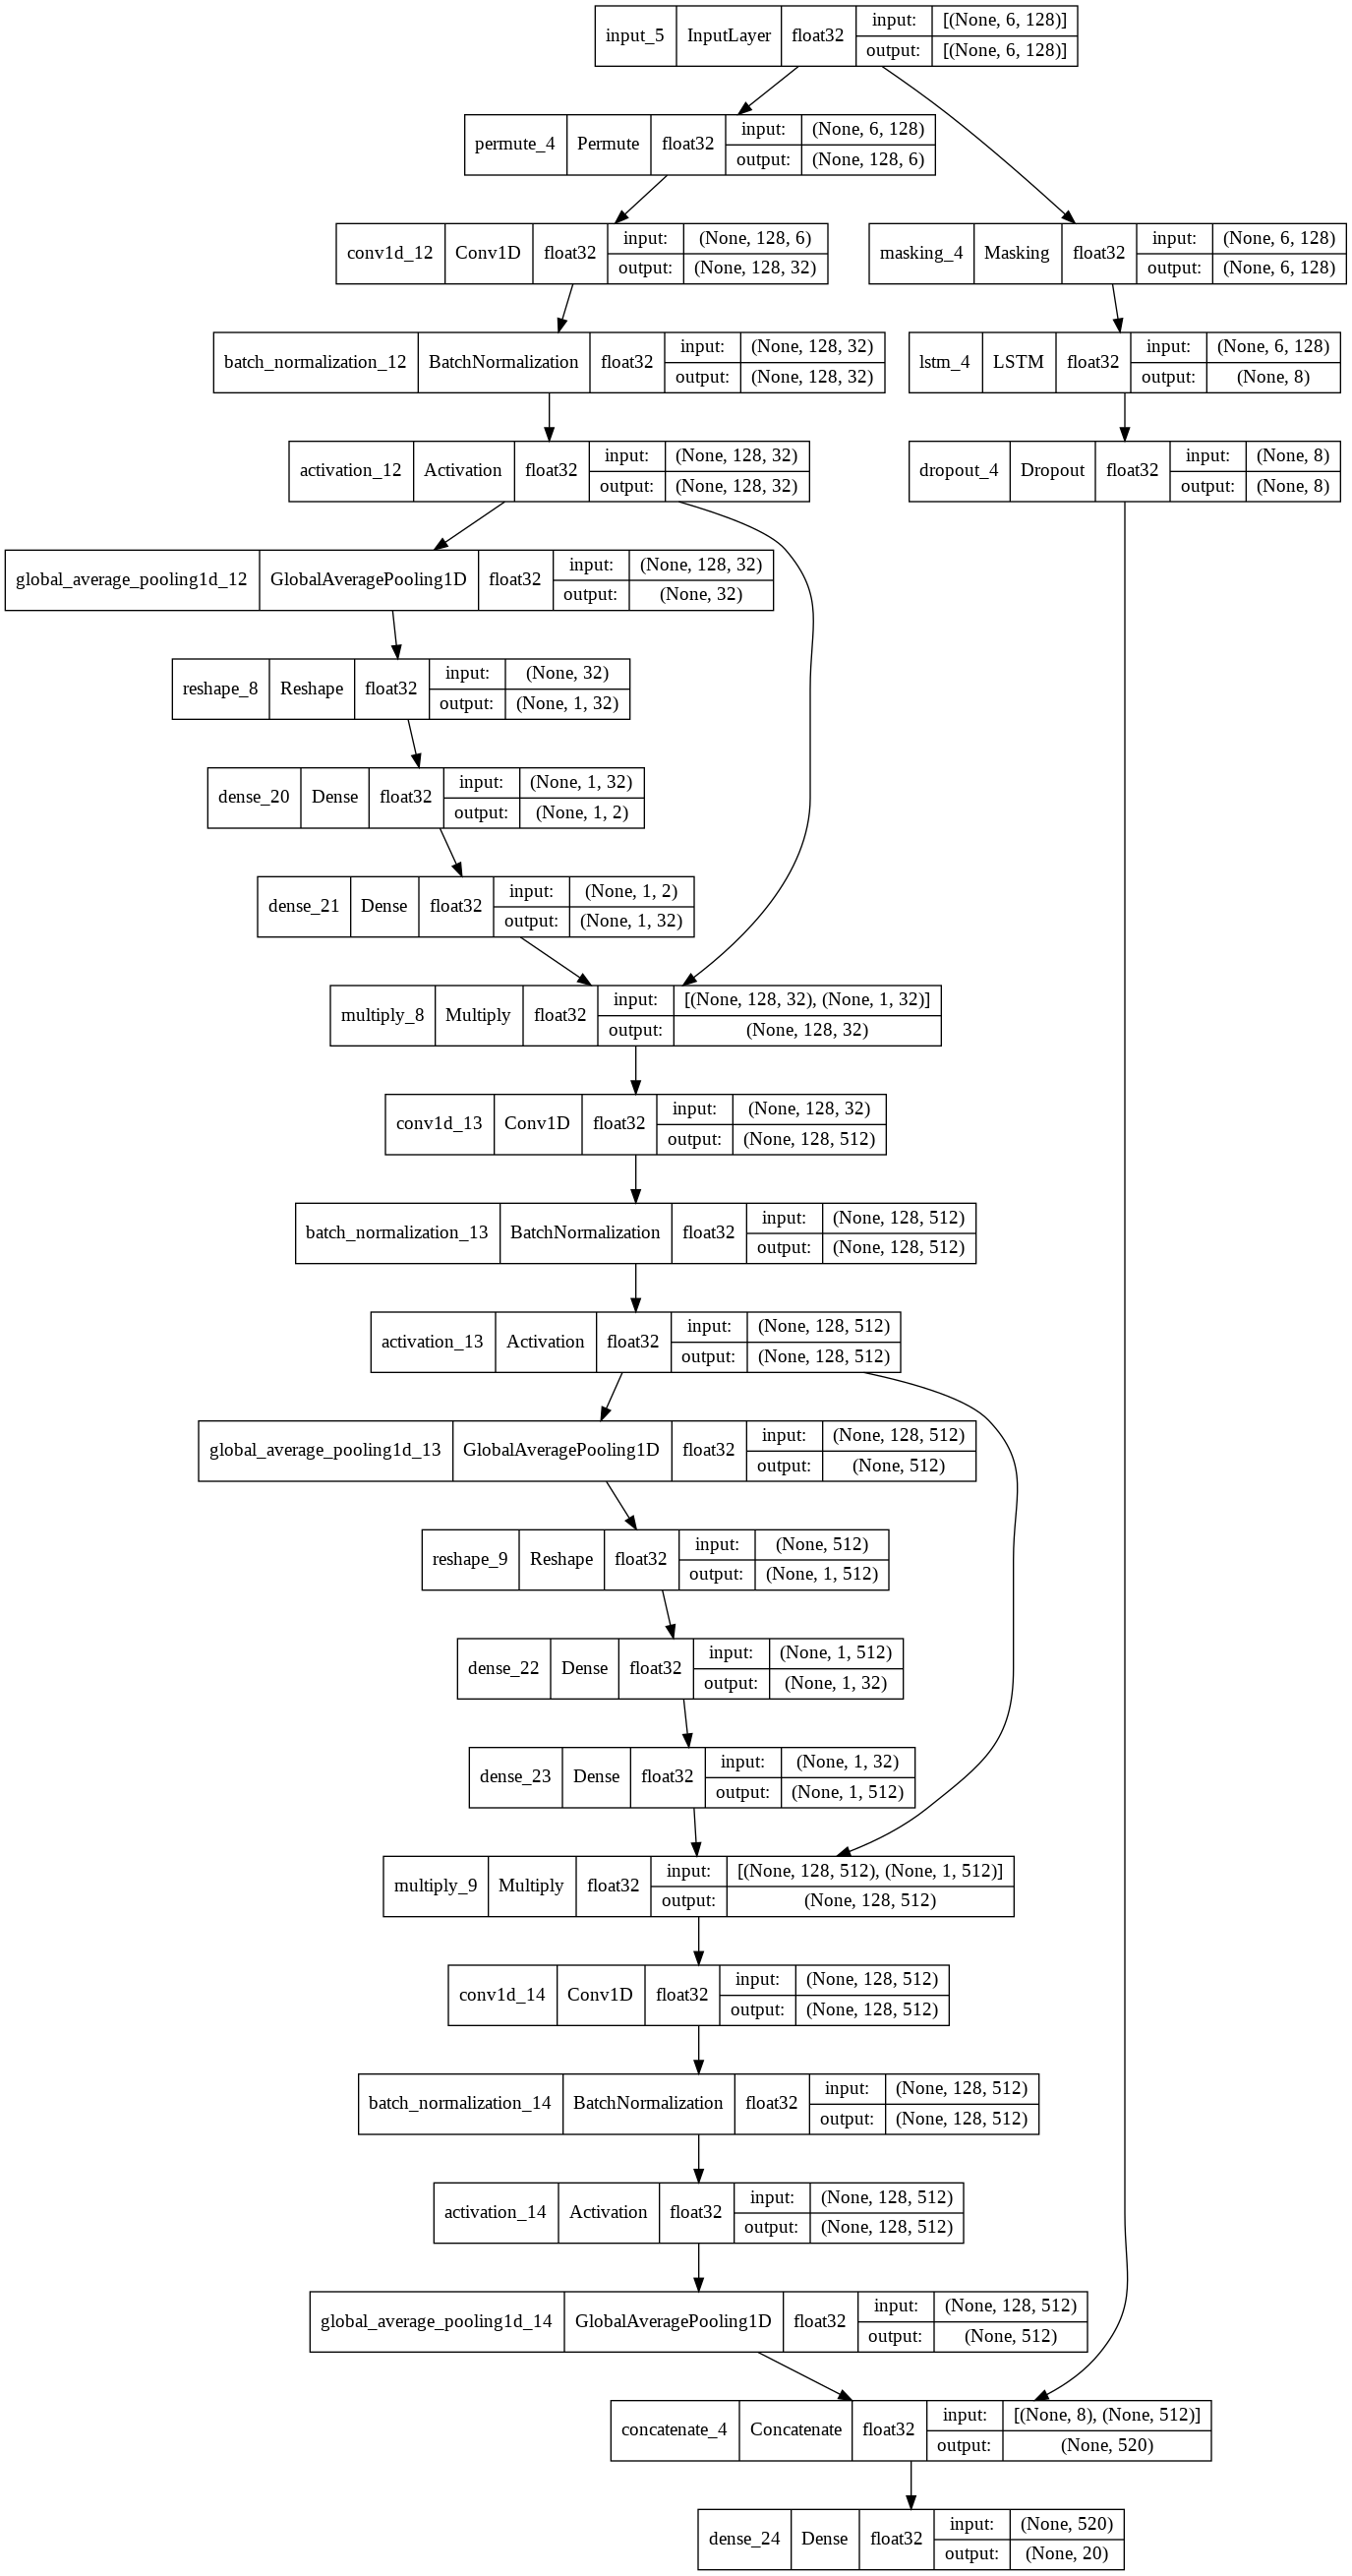

In [ ]:
tensorflow.keras.utils.plot_model(
    model, to_file='MLSTM_FCN_unified.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

# Grid search (Thousands of trials needed DO NOT TRY)

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

In [ ]:
def MLSTM_FCN(shape=shape, num_classes=num_classes, dropout_rate=0.0, neurons=10, filters1=8,filters2=8,filters3=8, strides1=1,strides2=1,strides3=1):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=neurons)(x)
    x = Dropout(dropout_rate)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(filters, strides, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(filters, strides, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(filters, strides, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile("adam", loss="categorical_crossentropy", metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

In [ ]:
model = KerasClassifier(build_fn=MLSTM_FCN, verbose=1)
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# learning_rate = [1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0]
neurons = [8,16,32,64,128,256,512]
# batch_size = [32,64,128,256,512,1024,2048,4096]
# epochs = [200]
filters1 = [32,64,128,256,512]
filters2= [32,64,128,256,512]
filters3 = [32,64,128,256,512]
strides1 = [3,5,7,8,9]
strides2 = [3,5,7,8,9]
strides3 = [3,5,7,8,9]

param_grid = dict(dropout_rate=dropout_rate, learning_rate=learning_rate, neurons=neurons, filters=filters, strides=strides, )
# fit_params={"early_stopping_rounds":30, "eval_metric":}
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, train_label, batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)